# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

Для начала прочитаем и просмотрим предоставленные нам данные:

In [2]:
df = pd.read_csv('datasets/hotel_train.csv')
df_test = pd.read_csv('datasets/hotel_test.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [4]:
df.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [5]:
df

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,84057,0,23.0,2016,December,53,30,2,4,2.0,...,0,0,0,D,0,0,Transient,0,2,6
65225,84063,0,53.0,2016,December,53,31,2,3,2.0,...,0,0,0,D,0,0,Transient,0,3,5
65226,84094,0,7.0,2016,December,53,31,2,4,2.0,...,0,0,0,D,0,0,Transient,0,1,6
65227,84117,0,17.0,2016,December,53,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,1,7


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [7]:
df_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [8]:
df_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164.0,2017,August,35,31,2,4,2.0,...,0,0,0,A,0,0,Transient,0,0,6
32408,97900,0,21.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,2,7
32409,97901,0,23.0,2017,August,35,30,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
32410,97902,0,34.0,2017,August,35,31,2,5,2.0,...,0,0,0,D,0,0,Transient,0,4,7


Данные прочитаны и просмотрены. Первое впечатление о данных: пропусков нет, аномальных значений, сильно выбивающихся из общей картины или данных которые явно являются неверными (например отрицательное количество дней), не замечено.

### Предобработка и исследовательский анализ данных

In [9]:
df['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [10]:
df['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [11]:
df['meal'] = df['meal'].apply(lambda x: x.replace(' ', ''))
df['reserved_room_type'] = df['reserved_room_type'].apply(lambda x: x.replace(' ', ''))
df_test['meal'] = df_test['meal'].apply(lambda x: x.replace(' ', ''))
df_test['reserved_room_type'] = df_test['reserved_room_type'].apply(lambda x: x.replace(' ', ''))

In [12]:
df['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [13]:
df['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [14]:
df_total = pd.concat([df, df_test], ignore_index=True)

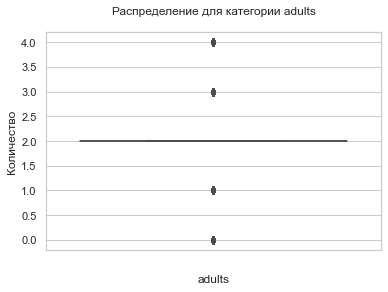

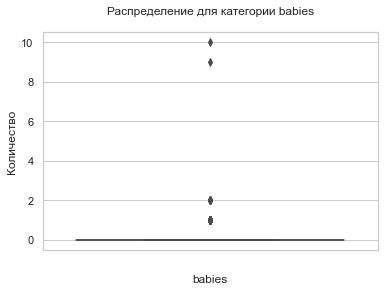

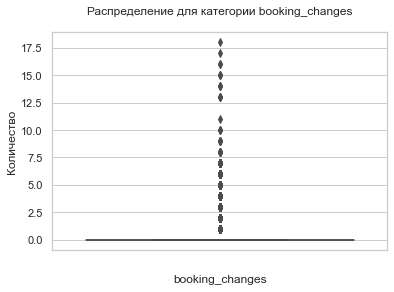

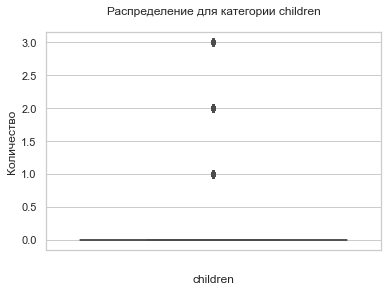

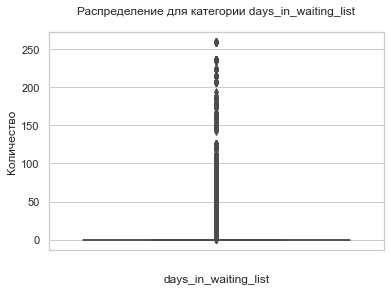

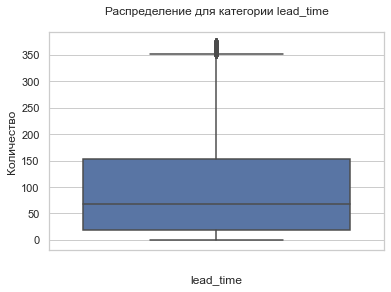

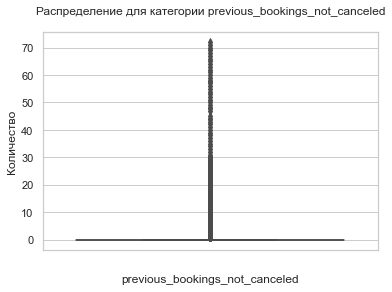

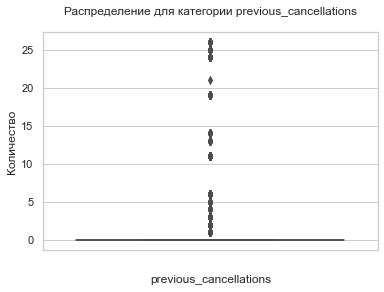

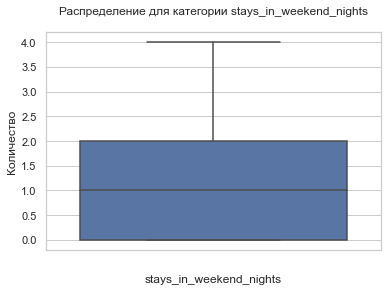

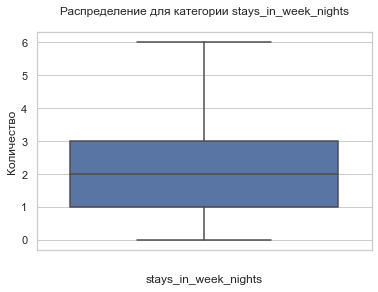

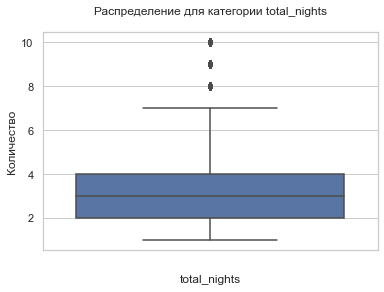

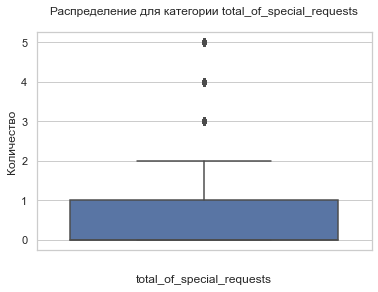

In [15]:
categories = ['adults', 
             'babies', 
             'booking_changes', 
             'children', 
             'days_in_waiting_list', 
             'lead_time', 
             'previous_bookings_not_canceled', 
             'previous_cancellations', 
             'stays_in_weekend_nights', 
             'stays_in_week_nights', 
             'total_nights', 
             'total_of_special_requests']

sns.set(style="whitegrid")

for cat in categories:
    fig = plt.figure()
    ax = sns.boxplot(y=df_total[cat])
    ax.set_title(f'Распределение для категории {cat}\n')
    ax.set_ylabel(ylabel='Количество')
    ax.set_xlabel(xlabel=f'\n{cat}')
    plt.show()

In [16]:
categories = ['adults', 
             'babies', 
             'booking_changes', 
             'days_in_waiting_list', 
             'lead_time', 
             'previous_bookings_not_canceled', 
             'previous_cancellations']

df_total[categories].describe()

,adults,babies,booking_changes,days_in_waiting_list,lead_time,previous_bookings_not_canceled,previous_cancellations
count,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000
mean,1.843887,0.006667,0.201729,2.314642,96.752839,0.128860,0.089972
std,0.483393,0.091790,0.609830,15.224212,93.045823,1.530961,0.797737
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,68.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,152.000000,0.000000,0.000000
max,4.000000,10.000000,18.000000,259.000000,374.000000,72.000000,26.000000


In [17]:
df = df[~df['babies'].isin([9,10])]
df_test = df_test[~df_test['babies'].isin([9,10])]
df_total = df_total[~df_total['babies'].isin([9,10])]
df_total['babies'].describe()

count    97639.000000
mean         0.006473
std          0.081083
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: babies, dtype: float64

In [18]:
df = df.drop(df[~df['booking_changes'].isin(range(0,4))].index)
df_test = df_test.drop(df_test[~df_test['booking_changes'].isin(range(0,4))].index)
df_total = df_total.drop(df_total[~df_total['booking_changes'].isin(range(0,4))].index)

df = df.drop(df[~df['days_in_waiting_list'].isin(range(0,49))].index)
df_test = df_test.drop(df_test[~df_test['days_in_waiting_list'].isin(range(0,49))].index)
df_total = df_total.drop(df_total[~df_total['days_in_waiting_list'].isin(range(0,49))].index)

df = df.drop(df[~df['lead_time'].isin(range(0,376))].index)
df_test = df_test.drop(df_test[~df_test['lead_time'].isin(range(0,376))].index)
df_total = df_total.drop(df_total[~df_total['lead_time'].isin(range(0,376))].index)

df = df.drop(df[~df['previous_bookings_not_canceled'].isin(range(0,6))].index)
df_test = df_test.drop(df_test[~df_test['previous_bookings_not_canceled'].isin(range(0,6))].index)
df_total = df_total.drop(df_total[~df_total['previous_bookings_not_canceled'].isin(range(0,6))].index)

df = df.drop(df[~df['previous_cancellations'].isin(range(0,4))].index)
df_test = df_test.drop(df_test[~df_test['previous_bookings_not_canceled'].isin(range(0,4))].index)
df_total = df_total.drop(df_total[~df_total['previous_bookings_not_canceled'].isin(range(0,4))].index)

df = df.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_total = df_total.reset_index(drop=True)

In [19]:
df_total.shape

(94546, 25)

In [20]:
df_test.shape

(31791, 25)

In [21]:
df.shape

(62824, 25)

In [22]:
df_total['id'].duplicated().sum()

0

По `id` дубликатов нет. Проверим по всему остальному:

In [23]:
df_total.drop('id', axis=1).duplicated(keep=False).sum()

34860

Интересно... Полного совпадения строк нет, но по всем столбцам, кроме `id`, дубликаты есть. Проверим, возможно для этих данных есть ярко выраженный тип заказчика.

In [24]:
df_total[df_total.drop('id', axis=1).duplicated(keep=False)].groupby('customer_type')['id'].count()

customer_type
Contract            1123
Group                 60
Transient          19271
Transient-Party    14406
Name: id, dtype: int64

Очень странно... Данных слишком много, что бы это было ошибкой, и в то же время они никак не связаны. Дубликаты не связаны групповыми заездами. Что ж, без возможности уточнения этих данных, можно предположить, что у большого количества людей совпадают графики отпусков.

Предварительно мы уже просмотрели данные, не заметив никаких критических ошибок. Но в сыром виде наши данные нам явно не подойдут, покольку у нас имеются некоторые столбца с данными типа `object`, следовательно при создании модели будут возникать проблемы с ними. Избавимся от категориальных данных в датафреймах при помощи `OrdinalEncoder`.

In [25]:
encoder = OrdinalEncoder()
df_col_for_transform = ['arrival_date_month', 'meal', 'distribution_channel', 'reserved_room_type', 'customer_type']

encoder.fit(df[df_col_for_transform])

df_ordinal_transformed = pd.DataFrame(encoder.transform(df[df_col_for_transform]), 
                                     columns=df[df_col_for_transform].columns,
                                     dtype=np.dtype(int))
df_test_ordinal_transformed = pd.DataFrame(encoder.transform(df_test[df_col_for_transform]), 
                                     columns=df_test[df_col_for_transform].columns,
                                     dtype=np.dtype(int))

df_ordinal = df.copy()
df_test_ordinal = df_test.copy()
df_ordinal[df_col_for_transform] = df_ordinal_transformed
df_test_ordinal[df_col_for_transform] = df_test_ordinal_transformed
display(df_ordinal.head(10))
display(df_test_ordinal.head(10))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,5,27,1,0,1,1.0,...,0,0,0,0,0,0,2,0,0,1
1,1,0,14.0,2015,5,27,1,0,2,2.0,...,0,0,0,0,0,0,2,0,1,2
2,2,0,0.0,2015,5,27,1,0,2,2.0,...,0,0,0,2,0,0,2,0,0,2
3,3,0,9.0,2015,5,27,1,0,2,2.0,...,0,0,0,2,0,0,2,0,1,2
4,4,1,85.0,2015,5,27,1,0,3,2.0,...,0,0,0,0,0,0,2,0,1,3
5,5,1,75.0,2015,5,27,1,0,3,2.0,...,0,0,0,3,0,0,2,0,0,3
6,6,1,23.0,2015,5,27,1,0,4,2.0,...,0,0,0,4,0,0,2,0,0,4
7,7,0,18.0,2015,5,27,1,0,4,2.0,...,0,0,0,6,1,0,2,0,1,4
8,8,0,68.0,2015,5,27,1,0,4,2.0,...,0,0,0,3,0,0,2,0,3,4
9,9,0,37.0,2015,5,27,1,0,4,2.0,...,0,0,0,4,0,0,0,0,0,4


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,4,1,1,1,0,2.0,...,0,0,0,0,0,0,2,0,0,1
1,6087,1,62.0,2017,4,1,1,2,2,2.0,...,0,0,0,0,0,0,2,0,1,4
2,6088,1,62.0,2017,4,1,1,2,2,2.0,...,0,0,0,0,0,0,2,0,1,4
3,6089,1,71.0,2017,4,1,1,2,2,1.0,...,0,0,0,0,0,0,2,0,1,4
4,6090,1,172.0,2017,4,1,1,2,5,2.0,...,0,0,0,0,0,0,2,0,0,7
5,6091,1,52.0,2017,4,1,1,2,5,1.0,...,0,0,0,0,0,0,2,0,0,7
6,6092,1,143.0,2017,4,1,2,1,1,2.0,...,0,0,0,0,1,0,2,0,1,2
7,6093,1,21.0,2017,4,1,2,1,3,2.0,...,0,0,0,0,0,0,2,0,1,4
8,6094,1,89.0,2017,4,1,2,1,3,2.0,...,0,0,0,4,0,0,2,0,0,4
9,6095,1,48.0,2017,4,1,2,1,4,2.0,...,0,0,0,0,1,0,2,0,2,5


In [26]:
country_data = pd.DataFrame([df.groupby('country')['id'].count(), df_test.groupby('country')['id'].count()]).T
country_data.columns=['train', 'test']
country_data = country_data.fillna(0)
country_data['sum'] = country_data['test'] + country_data['train']
country_data_sorted = country_data.sort_values('sum', ascending = False).head(10)
country_data_sorted

,train,test,sum
country,,,
PRT,27123.0,9466.0,36589.0
FRA,5857.0,3443.0,9300.0
GBR,5048.0,3884.0,8932.0
ESP,4849.0,1919.0,6768.0
DEU,3814.0,2363.0,6177.0
ITA,2277.0,1148.0,3425.0
IRL,1412.0,1050.0,2462.0
BEL,1229.0,878.0,2107.0
BRA,1074.0,877.0,1951.0


In [27]:
not_other = country_data_sorted[country_data_sorted['sum'] >= 2000].index
df['country'] = df['country'].where(df['country'].isin(not_other), 'other')
df_test['country'] = df_test['country'].where(df_test['country'].isin(not_other), 'other')

In [28]:
encoder_country = OrdinalEncoder()

country_list = pd.DataFrame(list(set(df['country'].unique().tolist() + df_test['country'].unique().tolist())))

encoder_country.fit(country_list)

df_ordinal_transformed_c = encoder_country.transform(df[['country']])
df_test_ordinal_transformed_c = encoder_country.transform(df_test[['country']])

df_ordinal['country'] = df_ordinal_transformed_c.astype('int')
df_test_ordinal['country'] = df_test_ordinal_transformed_c.astype('int')
display(df_ordinal['country'].head(10))
display(df_test_ordinal['country'].head(10))

C:\Users\artem\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
C:\Users\artem\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


0    4
1    4
2    7
3    7
4    7
5    7
6    7
7    2
8    5
9    7
Name: country, dtype: int32

0    7
1    8
2    8
3    7
4    0
5    1
6    8
7    8
8    4
9    7
Name: country, dtype: int32

Данные закодированы, можем приступать к работе с моделями.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Исходя из данного нам задания, необходимо создать модель, которая предскажет нам неблагонадежных клиентов, для которых необходимо будет внести депозит при бронировании. Предварительно рассчитаем прибыль отеля до внесения каких либо изменений, для этого напишем функцию:

In [29]:
SPRING = ['March', 'April', 'May']
SUMMER = ['June', 'July', 'August']
AUTUMN = ['September', 'October', 'November']
WINTER = ['December', 'January', 'Febuary']

ROOM_TYPE = {'A':[1000, 400],
             'B':[800, 350],
             'C':[600, 350],
             'D':[550, 150],
             'E':[500, 150],
             'F':[450, 150],
             'G':[350, 150]
            }

In [30]:
def profit(row):
    
    profit = 0
    coef = 0
    
    if row['arrival_date_month'] in (SPRING or AUTUMN):
        coef = 1.2
    elif row['arrival_date_month'] in SUMMER:
        coef = 1.4
    elif row['arrival_date_month'] in WINTER:
        coef = 1
        
    stayed = row['stays_in_weekend_nights'] + row['stays_in_week_nights']
    multipliers = ROOM_TYPE[row['reserved_room_type']]
    profit += multipliers[0] * stayed * coef
    profit -= multipliers[1] * (np.floor(stayed/2) + 1) ### в этой строке ничего не происходит *вроде поправил V.1*
    
    return profit

In [31]:
df['potentional_profit'] = df.apply(profit, axis=1)
df_test['potentional_profit'] = df_test.apply(profit, axis=1)
df['potentional_profit'].sum() + df_test['potentional_profit'].sum()

150909140.0

Если бы не было отмен, то отель заработал бы около 150 млн. Но отмены есть, посчитаем прибыль с учетом отмен:

In [32]:
df[df['is_canceled'] == 0].apply(profit, axis=1).sum() + df_test[df_test['is_canceled'] == 0].apply(profit, axis=1).sum()

91441780.0

Прибыль с учетом отмен чуть больше 91 млн. Потери весьма и весьма значимые, с учетом того, что в данном случае мы еще не учли затраты на подготовку номера и затраты на продукты для потенциального гостя. Оценить эти затраты мы не сможем, поскольку не знаем за какой срок до заезда была отменена бронь, за сколько закупаются продукты и получилось ли найти замену клиенту.

In [33]:
def cleaning(row):
    prices = ROOM_TYPE[row['reserved_room_type']]
    return prices[1]

In [34]:
test_profit_no_pred = (
    df_test[df_test['is_canceled'] == 0].apply(profit, axis=1).sum() - 
    df_test[df_test['is_canceled'] == 1].apply(cleaning, axis=1).sum()
)

test_profit_no_pred

39349640.0

Итак, можно утверждать, что прибыль с клиентов, указанных в тестовой выборке состовляет около 40 млн. с учетом отмен.

### Разработка модели ML

Приступим к работе с моделями. Для начала оценим значимость признаков, обучив первые модели:

In [35]:
target = df_ordinal['is_canceled']
features = df_ordinal.drop(['is_canceled', 'id'], axis=1)
params = {'max_depth': range(1,10,1),
          'max_features': range(1, 10, 1),
          'n_estimators': range(1,1000,100),
          'max_leaf_nodes': range(2,20,1)
         }

model = RandomizedSearchCV(RandomForestClassifier(random_state=25, class_weight='balanced'), 
                    params, 
                    cv=5,
                    pre_dispatch=3,
                    verbose=5,
                    n_iter = 30,
                    scoring='f1',
                    random_state=25,
                    n_jobs=-1
                    )

model.fit(features, target)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.5963735431235454
{'n_estimators': 501, 'max_leaf_nodes': 5, 'max_features': 7, 'max_depth': 8}


In [36]:
params = {'max_depth': range(6,9,1),
          'max_features': range(6, 9, 1),
          'n_estimators': range(450,551,25),
          'max_leaf_nodes': range(4,7,1)
         }

model = GridSearchCV(RandomForestClassifier(random_state=25, class_weight='balanced'), 
                    params, 
                    cv=5,
                    pre_dispatch=5,
                    verbose=5,
                    scoring='f1',
                    n_jobs=-1
                    )

model.fit(features, target)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
0.608349161828819
{'max_depth': 6, 'max_features': 8, 'max_leaf_nodes': 4, 'n_estimators': 475}


Изучим веса признаков:

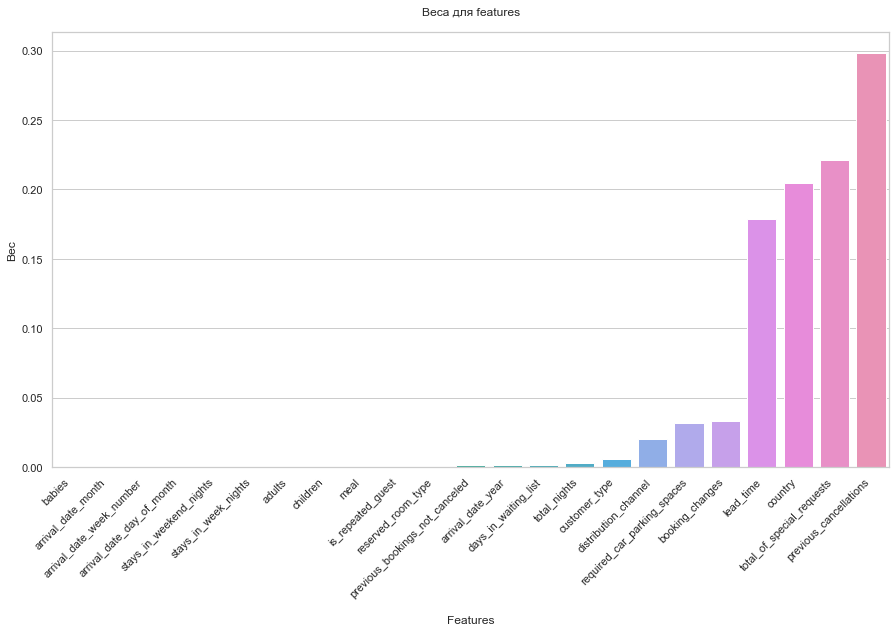

In [37]:
model = RandomForestClassifier(random_state=25, class_weight='balanced', max_depth=6, max_features = 8, n_estimators = 475, max_leaf_nodes=4)
model.fit(features, target)
data = pd.DataFrame(features.columns, model.feature_importances_).reset_index().sort_values(by='index')

fig = plt.figure(figsize=(15,8))

sns.set(style="whitegrid")
ax = sns.barplot(data = data, x=0, y='index')
ax.set_title('Веса для features\n')
ax.set_ylabel(ylabel='Вес')
ax.set_xlabel(xlabel='\nFeatures')

ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels())
plt.xticks(rotation=45, ha='right')
plt.show()

Исходя из полученных результатов исследования, можно сделать вывод, что достаточным для нас будет использование первых 8 признаков.

In [38]:
target_column = 'is_canceled'
features_columns = ['lead_time',
                    'total_of_special_requests',
                    'previous_cancellations',
                    'required_car_parking_spaces',
                    'booking_changes',
                    'distribution_channel',
                    'customer_type',
                   'country']

Обучим новую модель на основании этих признаков и проверим её точность:

In [39]:
target = df_ordinal[target_column]
features = df_ordinal[features_columns]
params = {'max_depth': range(1,10,1),
          'n_estimators': range(1,1000,100),
          'max_leaf_nodes': range(2,20,1)
         }

model = RandomizedSearchCV(RandomForestClassifier(random_state=25, class_weight='balanced'), 
                    params, 
                    cv=5,
                    pre_dispatch=3,
                    verbose=5,
                    n_iter = 50,
                    scoring='f1',
                    n_jobs=-1,
                    random_state=25
                    )

model.fit(features, target)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.6766213076926029
{'n_estimators': 201, 'max_leaf_nodes': 18, 'max_depth': 7}


Предварительно можно утверждать, что точность модели повысилась. Впоследствии будем работать с этими признаками. Проверим модель метрикой auc-roc и взглянем на метрику F1 и confusion matrix (на <b> ТЕСТОВЫХ </b> данных):

In [40]:
target_test = df_test_ordinal[target_column]
features_test = df_test_ordinal[features_columns]

In [41]:
prob = model.predict_proba(features_test)
prob_one = prob[:,1]
auc_roc = roc_auc_score(target_test, prob_one)
print('auc-roc:', auc_roc)
print('F1:', f1_score(target_test, model.predict(features_test)))
print(confusion_matrix(target_test, model.predict(features_test)))

auc-roc: 0.8212725108864215
F1: 0.6587471080263393
[[16718  2569]
 [ 5101  7403]]


Продолжим работать в направлении увеличесния метрики F1. Проведем уменьшение выборки, для уменьшения дисбаланса классов:

Мы провели уменьшение выборки, или же "downsampling". Теперь клиентов с отменой брони и без отмены брони примерно поровну. Попробуем обучить модель еще раз, и понаблюдаем за изменением F1 и других метрик:

In [42]:
params = {'random_forest__max_depth': range(6,10,1),
          'random_forest__n_estimators': range(350,451,50),
          'random_forest__max_leaf_nodes': range(13,19,1)
         }

pipeline = imbpipeline([['rus', RandomUnderSampler(random_state=25)], 
                        ['random_forest', RandomForestClassifier(random_state=25, class_weight='balanced')]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=25)

random_search_ds = RandomizedSearchCV(pipeline, 
                    param_distributions = params, 
                    cv=stratified_kfold,
                    pre_dispatch=3,
                    verbose=5,
                    n_iter = 20,
                    scoring='f1',
                    n_jobs=-1,
                    random_state=25
                    )

random_search_ds.fit(features, target)
print(random_search_ds.best_score_)
print(random_search_ds.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.7356127403641314
{'random_forest__n_estimators': 400, 'random_forest__max_leaf_nodes': 18, 'random_forest__max_depth': 7}


In [43]:
prob = random_search_ds.predict_proba(features_test)
prob_one = prob[:,1]
auc_roc = roc_auc_score(target_test, prob_one)
print(random_search_ds.best_score_)
print(random_search_ds.best_params_)
print('auc-roc:', auc_roc)
print('F1:', f1_score(target_test, random_search_ds.predict(features_test)))
print(confusion_matrix(target_test, random_search_ds.predict(features_test)))

0.7356127403641314
{'random_forest__n_estimators': 400, 'random_forest__max_leaf_nodes': 18, 'random_forest__max_depth': 7}
auc-roc: 0.8260774978926431
F1: 0.6457721188377408
[[17273  2014]
 [ 5581  6923]]


In [44]:
params = {'random_forest__max_depth': range(6,10,1),
          'random_forest__n_estimators': range(350,451,50),
          'random_forest__max_leaf_nodes': range(13,19,1)
         }

pipeline = imbpipeline([['smote', SMOTE(random_state=25)], 
                        ['random_forest', RandomForestClassifier(random_state=25, class_weight='balanced')]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=25)

random_search_sm = RandomizedSearchCV(estimator = pipeline,
                    param_distributions = params, 
                    cv=stratified_kfold,
                    pre_dispatch=3,
                    verbose=5,
                    n_iter = 20,
                    scoring='f1',
                    n_jobs=-1,
                    random_state=25
                    )

random_search_sm.fit(features, target)
print(random_search_sm.best_score_)
print(random_search_sm.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.7360666249940556
{'random_forest__n_estimators': 350, 'random_forest__max_leaf_nodes': 18, 'random_forest__max_depth': 7}


In [45]:
print(random_search_sm.best_score_)
print(random_search_sm.best_params_)
prob = random_search_sm.predict_proba(features_test)
prob_one = prob[:,1]
auc_roc = roc_auc_score(target_test, prob_one)
print('auc-roc:', auc_roc)
print('F1:', f1_score(target_test, random_search_sm.predict(features_test)))
print(confusion_matrix(target_test, random_search_sm.predict(features_test)))

0.7360666249940556
{'random_forest__n_estimators': 350, 'random_forest__max_leaf_nodes': 18, 'random_forest__max_depth': 7}
auc-roc: 0.8232738925317113
F1: 0.6675889498940815
[[16381  2906]
 [ 4783  7721]]


In [46]:
params = {'lgb__num_leaves': range(1,101,5),
          'lgb__min_data_in_leaf': range(1,10,1),
          'lgb__max_depth': range(1,11,1)          
         }

pipeline = imbpipeline([['rus', RandomUnderSampler(random_state=25)], 
                        ['lgb', LGBMClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=25)

lgb_ds = RandomizedSearchCV(pipeline, 
                    param_distributions = params, 
                    cv=stratified_kfold,
                    pre_dispatch=3,
                    verbose=5,
                    scoring='f1',
                    n_jobs=-1,
                    random_state=25,
                    n_iter=20
                    )

lgb_ds.fit(features, target)
print(lgb_ds.best_score_)
print(lgb_ds.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
0.7701120434354132
{'lgb__num_leaves': 51, 'lgb__min_data_in_leaf': 6, 'lgb__max_depth': 10}


In [47]:
prob = lgb_ds.predict_proba(features_test)
prob_one = prob[:,1]
auc_roc = roc_auc_score(target_test, prob_one)
print(lgb_ds.best_score_)
print(lgb_ds.best_params_)
print('auc-roc:', auc_roc)
print('F1:', f1_score(target_test, lgb_ds.predict(features_test)))
print(confusion_matrix(target_test, lgb_ds.predict(features_test)))

0.7701120434354132
{'lgb__num_leaves': 51, 'lgb__min_data_in_leaf': 6, 'lgb__max_depth': 10}
auc-roc: 0.8374749685534341
F1: 0.6728480248404348
[[16404  2883]
 [ 4703  7801]]


In [48]:
params = {'lgb__num_leaves': range(1,101,5),
          'lgb__min_data_in_leaf': range(1,10,1),
          'lgb__max_depth': range(1,11,1)          
         }

pipeline = imbpipeline([['smote', SMOTE(random_state=25)], 
                        ['lgb', LGBMClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=25)

lgb_sm = RandomizedSearchCV(pipeline, 
                    param_distributions = params, 
                    cv=stratified_kfold,
                    pre_dispatch=3,
                    verbose=5,
                    scoring='f1',
                    n_jobs=-1,
                    random_state=25,
                    n_iter=20
                    )

lgb_sm.fit(features, target)
print(lgb_sm.best_score_)
print(lgb_sm.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
0.769986305433625
{'lgb__num_leaves': 51, 'lgb__min_data_in_leaf': 6, 'lgb__max_depth': 10}


In [49]:
print(lgb_sm.best_score_)
print(lgb_sm.best_params_)
prob = lgb_sm.predict_proba(features_test)
prob_one = prob[:,1]
auc_roc = roc_auc_score(target_test, prob_one)
print('auc-roc:', auc_roc)
print('F1:', f1_score(target_test, lgb_sm.predict(features_test)))
print(confusion_matrix(target_test, lgb_sm.predict(features_test)))

0.769986305433625
{'lgb__num_leaves': 51, 'lgb__min_data_in_leaf': 6, 'lgb__max_depth': 10}
auc-roc: 0.8335040838987313
F1: 0.6717197670435081
[[16282  3005]
 [ 4661  7843]]


#### Вывод

Лучше всего себя показала модель LightGBM с использованием SMOTE для метрики F1.

Модель обучена, теперь можем посчитать, сколько потерь получилось бы предотвратить, основываясь на предсказаниях модели:

In [50]:
def deposit(row):
    
    deposit = 0
    coef = 0
    
    if row['arrival_date_month'] in (SPRING or AUTUMN):
        coef = 1.2
    elif row['arrival_date_month'] in SUMMER:
        coef = 1.4
    elif row['arrival_date_month'] in WINTER:
        coef = 1
    
    price = ROOM_TYPE[row['reserved_room_type']]
    deposit = (price[0] * coef + price[1]) * 0.8 
    
    return deposit

In [51]:
df_test['predict'] = lgb_ds.predict(features_test)
df['predict'] = lgb_ds.predict(features)
df_final = pd.concat([df, df_test], ignore_index=True)

In [52]:
df['deposit'] = df.apply(deposit, axis=1)
df_test['deposit'] = df_test.apply(deposit, axis=1)
df_total['deposit'] = df_total.apply(deposit, axis=1)

In [53]:
df[(df['predict'] == 1) & (df['is_canceled'] == 1)]['deposit'].sum() + df_test[(df_test['predict']==1) & (df_test['is_canceled']==1)]['deposit'].sum()

23801952.0

Из этого можно сделать вывод, что за все время, если бы использовалась модель для предсказания взятия депозита, то получилось бы сэкономить почти 24 млн на отменненых заказах. А сколько же получилось бы сэкономить за год? (Для оценки возьмем 2016 год)

In [54]:
(df[(df['predict'] == 1) & (df['is_canceled'] == 1) & (df['arrival_date_year'] == 2016)]['deposit'].sum() 
 + df_test[(df_test['predict']==1) & (df_test['is_canceled']==1) & (df_test['arrival_date_year'] == 2016)]['deposit'].sum())

10077144.0

Итак, за 2016 год получилось бы сэкономить 101 млн. Что покрывает затраты на разработку модели. Посмотрим, какой для скольки процентов посетителей модель рекомендует брать депозит:

In [55]:
(df['predict'].mean() + df_test['predict'].mean())/2

0.3556543595812526

Примерно для 36% посетителей рекомендуется требовать депозит. Что соотносимо с количеством отмен, которое мы оценивали в начале исследования.

In [56]:
df_test[(df_test['predict']==1) & (df_test['is_canceled']==1)]['deposit'].sum()

8768152.0

In [57]:
print('Прибыль с использованием модели:')
(df_test[df_test['is_canceled']==0]['potentional_profit'].sum() +
 df_test[(df_test['predict']==1) & (df_test['is_canceled']==1)]['deposit'].sum() -
 (df_test[(df_test['is_canceled']==1)]['reserved_room_type'].transform(lambda x: ROOM_TYPE[x][1])).sum())

Прибыль с использованием модели:


48117792.0

In [58]:
print('Прибыль без использования модели:')
(df_test[df_test['is_canceled']==0]['potentional_profit'].sum() -
(df_test[(df_test['is_canceled']==1)]['reserved_room_type'].transform(lambda x: ROOM_TYPE[x][1])).sum())

Прибыль без использования модели:


39349640.0

### Опишем портрет «ненадёжного» клиента

Исходя из тех параметров, на которых мы обучали модель, можно сделать предположение о типичном "ненадежном" клиенте:

In [78]:
df_final[df_final['is_canceled']==1][features_columns].mean()

C:\Users\artem\AppData\Local\Temp\ipykernel_5728\663699182.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_final[df_final['is_canceled']==1][features_columns].mean()


lead_time                      130.419784
total_of_special_requests        0.325882
previous_cancellations           0.149494
required_car_parking_spaces      0.000000
booking_changes                  0.080033
dtype: float64

In [79]:
df_final[features_columns].mean()

C:\Users\artem\AppData\Local\Temp\ipykernel_5728\2313762104.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_final[features_columns].mean()


lead_time                      95.265444
total_of_special_requests       0.567458
previous_cancellations          0.057560
required_car_parking_spaces     0.052846
booking_changes                 0.179993
dtype: float64

In [61]:
df_canceled_distribution_channel = df_final[df_final['is_canceled']==1].groupby('distribution_channel')['id'].count().sort_values(ascending=False)

In [62]:
df_distribution_channel = df_final.groupby('distribution_channel')['id'].count().sort_values(ascending=False)

In [63]:
df_by_channel = pd.DataFrame([df_canceled_distribution_channel, df_distribution_channel]).T
df_by_channel.columns = ['canceled', 'total']
df_by_channel

,canceled,total
distribution_channel,,
TA/TO,32462,79318
Direct,1800,10301
Corporate,1178,4812
GDS,33,184


In [64]:
df_by_channel['ratio'] = df_by_channel['canceled'] / df_by_channel['total']
df_by_channel

,canceled,total,ratio
distribution_channel,,,
TA/TO,32462,79318,0.409264
Direct,1800,10301,0.174740
Corporate,1178,4812,0.244805
GDS,33,184,0.179348


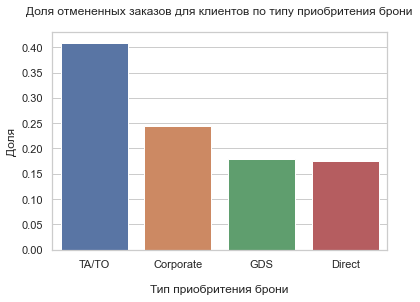

In [65]:
fig = plt.figure()

sns.set(style="whitegrid")
ax = sns.barplot(data = df_by_channel.sort_values('ratio', ascending=False), x=df_by_channel.sort_values('ratio', ascending=False).index, y='ratio')
ax.set_title('Доля отмененных заказов для клиентов по типу приобритения брони\n')
ax.set_ylabel(ylabel='Доля')
ax.set_xlabel(xlabel='\nТип приобритения брони')

plt.show()

In [66]:
df_canceled_customer_type = df_final[df_final['is_canceled']==1].groupby('customer_type')['id'].count().sort_values(ascending=False)

In [67]:
df_customer_type = df_final.groupby('customer_type')['id'].count().sort_values(ascending=False)

In [68]:
df_by_customer_type = pd.DataFrame([df_canceled_customer_type, df_customer_type]).T
df_by_customer_type.columns = ['canceled', 'total']
df_by_customer_type

,canceled,total
customer_type,,
Transient,28924,71251
Transient-Party,5382,19827
Contract,1135,3100
Group,32,437


In [69]:
df_by_channel['ratio'] = df_by_channel['canceled'] / df_by_channel['total']
df_by_channel

,canceled,total,ratio
distribution_channel,,,
TA/TO,32462,79318,0.409264
Direct,1800,10301,0.174740
Corporate,1178,4812,0.244805
GDS,33,184,0.179348


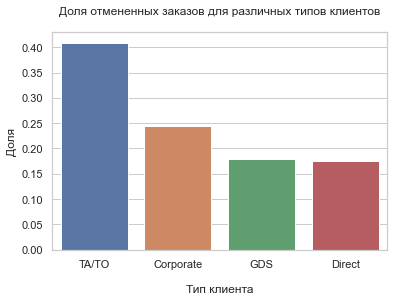

In [70]:
fig = plt.figure()

sns.set(style="whitegrid")
ax = sns.barplot(data = df_by_channel.sort_values('ratio', ascending=False), x=df_by_channel.sort_values('ratio', ascending=False).index, y='ratio')
ax.set_title('Доля отмененных заказов для различных типов клиентов\n')
ax.set_ylabel(ylabel='Доля')
ax.set_xlabel(xlabel='\nТип клиента')

plt.show()

In [71]:
df_canceled_by_country = df_final[df_final['is_canceled']==1].groupby('country')['id'].count().sort_values(ascending=False)
df_canceled_by_country

country
PRT      21442
other     5233
GBR       1998
FRA       1718
ESP       1690
ITA       1250
DEU       1108
IRL        622
BEL        412
Name: id, dtype: int64

In [72]:
df_groupped_by_country = df_final.groupby('country')['country'].count().sort_values(ascending=False)
df_by_country = pd.DataFrame([df_canceled_by_country, df_groupped_by_country]).T
df_by_country.columns = ['canceled', 'total']
df_by_country

,canceled,total
country,,
PRT,21442,36589
other,5233,18855
GBR,1998,8932
FRA,1718,9300
ESP,1690,6768
ITA,1250,3425
DEU,1108,6177
IRL,622,2462
BEL,412,2107


In [73]:
df_by_country['ratio'] = df_by_country['canceled'] / df_by_country['total']
df_by_country

,canceled,total,ratio
country,,,
PRT,21442,36589,0.586023
other,5233,18855,0.277539
GBR,1998,8932,0.223690
FRA,1718,9300,0.184731
ESP,1690,6768,0.249704
ITA,1250,3425,0.364964
DEU,1108,6177,0.179375
IRL,622,2462,0.252640
BEL,412,2107,0.195539


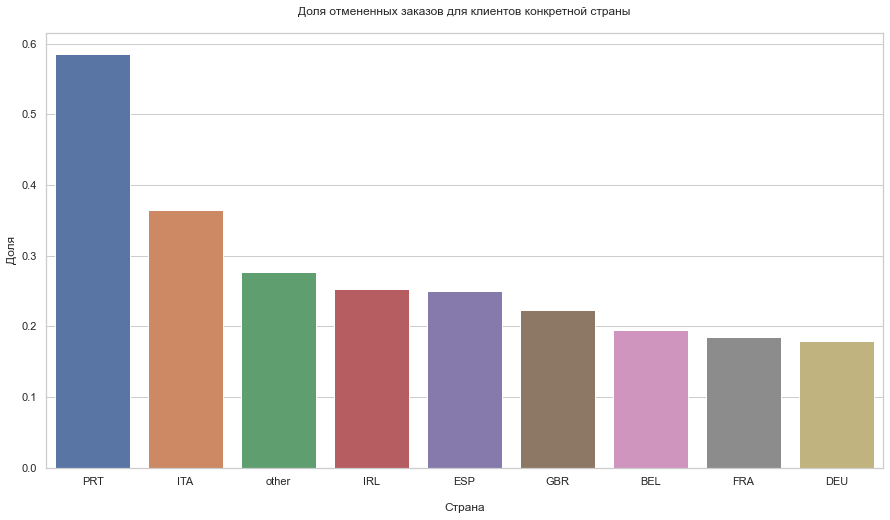

In [74]:
fig = plt.figure(figsize=(15,8))

sns.set(style="whitegrid")
ax = sns.barplot(data = df_by_country.sort_values('ratio', ascending=False), x=df_by_country.sort_values('ratio', ascending=False).index, y='ratio')
ax.set_title('Доля отмененных заказов для клиентов конкретной страны\n')
ax.set_ylabel(ylabel='Доля')
ax.set_xlabel(xlabel='\nСтрана')

plt.show()

Исходя из этих данных, можно утверждать, что "ненадежный" клиент это клиент, который создал бронь задолго до посещения (более чем за 100 дней), почти не делал специальных отметок, достаточно часто отменял бронь в прошлом, не указывал о необходимости парковочного места, не изменял параметры заказа, оформлял бронь через турагенство и не связан с договором или групповым заездом.

### Шаг 6. Напишем общий вывод

Исходя из всего выше написанного можно утверждать, что примерно 35% (как по предсказанию модели, так и по факту) клиентов отменяют бронь. Также можно утверждать, что на основании обученной модели можно успешно компенсировать часть расходов, причем не затрагивая "благонадежных" клиентов, которым не свойственно отменять бронь.

Но к сожалению ввод данной системы все равно повлечет какой-то отток клиентов, поскольку не всегда "неблагонадежные" клиенты (по мнению модели) отменяют бронь. Поэтому я бы рассмотрел иные схемы по оформлению брони.